In [5]:
# %% [code]
import os
import sys
import argparse
import ast
import re
import numpy as np
import torch
import torch.optim as optim
import urllib3
import matplotlib.pyplot as plt

# Add project root to path so we can import modules from the api, ai folders, etc.
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

# Disable HTTPS warnings.
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Import helper functions for building action/card representations.
from api.replay import parse_card

from experiment import build_action_rep_for_state, to_torch_input

# Import our API functions.
from api.playSlumbot import Login, NewHand, PlayHand, Act, get_street_name, parse_action_enhanced, \
    ChooseActionAI, index_to_action_string, STACK_SIZE, SMALL_BLIND, BIG_BLIND

# Import our model and PPO utilities.
from siamese_net import PseudoSiameseNet, logits_to_probs, clone_model_weights
from ppo_utils import a_gae, tc_loss_function, ratio, r_gamma, v_loss, make_model_value_function

# Import our experience gathering functions.
from api.replay import build_replay_experiences

# Import our HandResult grouping functions.
from hand_result import create_hands_from_experiences, build_experiences_from_txt  # ensure this file is in your project

# Set constants (if not already imported)
NUM_STREETS = 4


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [28]:
def play_batch(num_hands, token, policy_net, replay_path="replay.txt"):
    total_winnings = 0
    # Clear previous replay file.
    open(replay_path, "w").close()
    
    for h in range(num_hands):
        print(f"\n=== Playing hand #{h+1} ===")
        token, w, final_action, hole_cards, board, client_pos = PlayHand(token, policy_net=policy_net)
        total_winnings += (w or 0)
        with open(replay_path, "a") as f:
            # Format: hand_index,final_action,board,hole_cards,client_pos,winnings
            f.write(f"{h+1},{final_action},{board},{hole_cards},{client_pos},{w}\n")
    
    avg_bb = total_winnings / (num_hands * BIG_BLIND)
    print(f"\nBatch DONE. Total winnings: {total_winnings}, mBB/hand: {avg_bb:.3f}")
    return token, total_winnings, avg_bb

def run_one_iteration(iter_idx: int, rounds_array, old_policy_net, new_policy_net, optimizer):
    """
    Executes a single PPO update iteration on the given rounds_array.
    Returns average policy loss, average value loss, and number of steps.
    """
    print(f"\n=== Training Iteration {iter_idx} ===")
    total_pol_loss = 0
    total_val_loss = 0
    steps_count = 0

    model_value_func = make_model_value_function(new_policy_net)
    states, rewards = zip(*[(r["state"], r["reward"]) for r in rounds_array])
    
    for i, round_ in enumerate(rounds_array):
        deltas = round_['deltas']
        action_taken = round_['action_taken']
        state = round_['state']

        if i < len(rounds_array) - 1:
            future_rewards = rewards[i:]
            future_states  = states[i:]
            advantage_t = a_gae(future_states, future_rewards, model_value_func, gamma=0.999, lambda_=0.99)
        else:
            future_rewards = [round_["reward"]]
            advantage_t = torch.tensor(0.0)

        card_tensor = state[0]
        action_tensor = state[1]
        action_t, card_t = to_torch_input(card_tensor, action_tensor)
        
        old_logits, _ = old_policy_net.forward(action_t, card_t)
        old_probs = logits_to_probs(old_logits)[0].detach().cpu().numpy()

        new_logits, new_value = new_policy_net.forward(action_t, card_t)
        new_probs_t = logits_to_probs(new_logits)[0]
        new_probs = new_probs_t.detach().cpu().numpy()

        ratio_t = ratio(old_probs, new_probs, action_taken)
        pol_loss_tensor = tc_loss_function(ratio_t, advantage_t, epsilon=0.2)
        pol_loss_val = pol_loss_tensor.item()

        r_g = r_gamma(np.array(future_rewards), gamma=0.999)
        val_loss_tensor = v_loss(r_g, state, deltas, new_value)
        val_loss_val = val_loss_tensor.item()

        # chosen_log_prob = torch.log(new_probs_t[action_taken] + 1e-8)

        # combined_loss = -pol_loss_tensor * chosen_log_prob + (new_value[0] - val_loss_tensor)**2
        c = 1
        combined_loss = -pol_loss_tensor + c * val_loss_tensor

        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        total_pol_loss += pol_loss_val
        total_val_loss += val_loss_val
        steps_count += 1
        print(f"  Iter {iter_idx} round {i}: pol_loss={pol_loss_val:.3f}, val_loss={val_loss_val:.3f}")

    avg_pol = total_pol_loss / steps_count if steps_count > 0 else 0
    avg_val = total_val_loss / steps_count if steps_count > 0 else 0
    print(f"=> Iteration {iter_idx} done. avg pol_loss={avg_pol:.3f}, avg val_loss={avg_val:.3f}")
    return avg_pol, avg_val, steps_count

def train_model(model, hand_results):
    """
    Trains the model on the provided hand_results.
    Returns the updated model along with overall average policy and value losses.
    """
    old_policy_net = PseudoSiameseNet()
    new_policy_net = PseudoSiameseNet()
    clone_model_weights(model, old_policy_net)
    clone_model_weights(model, new_policy_net)
    optimizer = optim.Adam(new_policy_net.parameters(), lr=0.0001)
    
    total_pol_loss = 0
    total_val_loss = 0
    total_steps = 0
    for i, hand_result in enumerate(hand_results):
        avg_pol, avg_val, steps = run_one_iteration(i, hand_result.rounds, old_policy_net, new_policy_net, optimizer)
        total_pol_loss += avg_pol * steps
        total_val_loss += avg_val * steps
        total_steps += steps
    clone_model_weights(new_policy_net, old_policy_net)
    overall_avg_pol = total_pol_loss / total_steps if total_steps > 0 else 0
    overall_avg_val = total_val_loss / total_steps if total_steps > 0 else 0
    return new_policy_net, overall_avg_pol, overall_avg_val

In [29]:
# %% [code]
num_cycles = 10
num_hands_per_cycle = 100

# These lists will store metrics per cycle (averaged per 100 hands within each cycle).
avg_bb_list = []
avg_pol_loss_list = []
avg_val_loss_list = []
cycle_numbers = []

# Initialize token and policy network.
token = None  # Set token manually or via Login(username, password) if desired.
policy_net = PseudoSiameseNet()

for cycle in range(num_cycles):
    print(f"\n=== Cycle {cycle+1} ===")
    
    # 1. Play a new batch of hands and record replay file.
    token, batch_total_winnings, batch_avg_bb = play_batch(num_hands_per_cycle, token, policy_net, replay_path="replay.txt")
    avg_bb_list.append(batch_avg_bb)
    
    # 2. Load experiences from the replay file.
    experiences = build_experiences_from_txt("replay.txt")
    print(f"Cycle {cycle+1}: Loaded {len(experiences)} experiences.")
    
    # 3. Group experiences into hand-level training examples.
    hand_results = create_hands_from_experiences(experiences)
    print(f"Cycle {cycle+1}: Created {len(hand_results)} hand results.")
    
    # 4. Split hand_results into groups of 100 and train on each group.
    group_pol_losses = []
    group_val_losses = []
    for i in range(0, len(hand_results), num_hands_per_cycle):
        group = hand_results[i:i+num_hands_per_cycle]
        policy_net, avg_pol, avg_val = train_model(policy_net, group)
        group_pol_losses.append(avg_pol)
        group_val_losses.append(avg_val)
    cycle_avg_pol = np.mean(group_pol_losses) if group_pol_losses else 0
    cycle_avg_val = np.mean(group_val_losses) if group_val_losses else 0
    avg_pol_loss_list.append(cycle_avg_pol) 
    avg_val_loss_list.append(cycle_avg_val)
    cycle_numbers.append(cycle+1)
    
    print(f"Cycle {cycle+1} complete. Avg mBB/hand: {batch_avg_bb:.3f}, Avg policy loss: {cycle_avg_pol:.3f}, Avg value loss: {cycle_avg_val:.3f}")
    
    # Clear replay file for the next cycle.
    open("replay.txt", "w").close()

# %% [code]
# Plot the average mBB/hand and average losses over cycles.



=== Cycle 1 ===

=== Playing hand #1 ===

NEW HAND STARTED
Token: a46550c2-505d-43ce-8f46-37c927596bf3
Hero seat=0 => Big Blind
Hole cards: ['7s', '7c'], Board: No board
Initial action: 'b200'

Street: Preflop, next_to_act=0, action so far='b200'
Hero's hole cards: ['7s', '7c'], Board: No board
Playing action with policy network.
Action probs: [0.14527164 0.         0.15127228 0.         0.14247636 0.14420193
 0.13527788 0.14484946 0.13665046]
Hero's action => 'f'
Updated action => 'b200f', Board=No board
Hand ended immediately, winnings=-100


=== Playing hand #2 ===

NEW HAND STARTED
Token: a46550c2-505d-43ce-8f46-37c927596bf3
Hero seat=1 => Small Blind
Hole cards: ['Ac', '7c'], Board: No board
Initial action: ''

Street: Preflop, next_to_act=1, action so far=''
Hero's hole cards: ['Ac', '7c'], Board: No board
Playing action with policy network.
Action probs: [0.14512227 0.         0.15125892 0.         0.14255837 0.14426777
 0.13527624 0.14492393 0.1365925 ]
Hero's action => 'b275'

KeyboardInterrupt: 

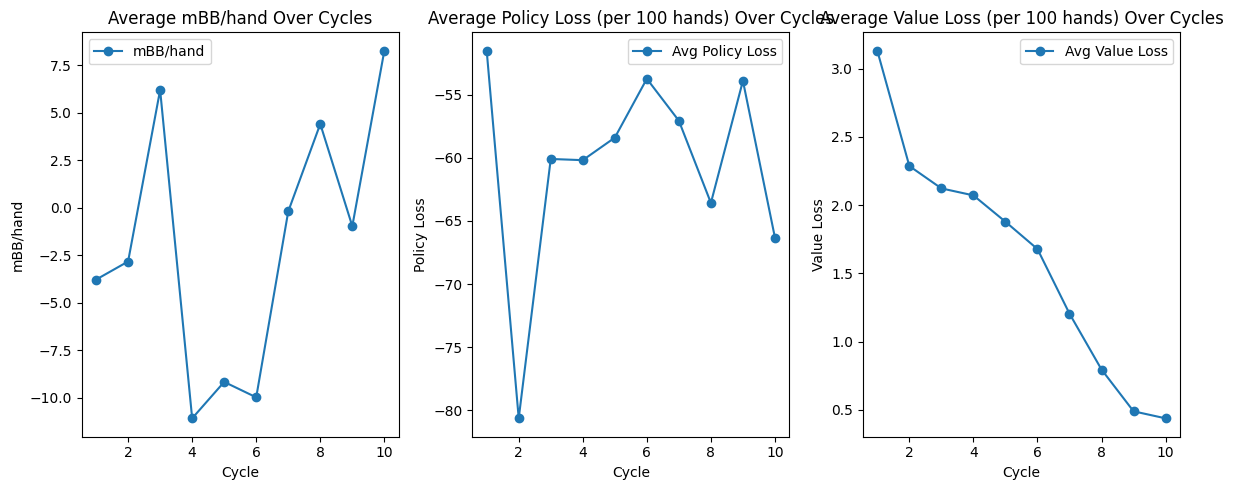

In [26]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(cycle_numbers, avg_bb_list, marker='o', label="mBB/hand")
plt.xlabel("Cycle")
plt.ylabel("mBB/hand")
plt.title("Average mBB/hand Over Cycles")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cycle_numbers, avg_pol_loss_list, marker='o', label="Avg Policy Loss")
plt.xlabel("Cycle")
plt.ylabel("Policy Loss")
plt.title("Average Policy Loss (per 100 hands) Over Cycles")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(cycle_numbers, avg_val_loss_list, marker='o', label="Avg Value Loss")
plt.xlabel("Cycle")
plt.ylabel("Value Loss")
plt.title("Average Value Loss (per 100 hands) Over Cycles")
plt.legend()

plt.tight_layout()
plt.show()
